In [1]:
# Set up environment
using Pkg
Pkg.activate(".")
Pkg.instantiate()

Activating environment at `~/Dropbox/working_dir/ccs19singapore/code/Project.toml`
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % [=========>                               ]  20.8 %]  41.3 %>        ]  79.1 % [========================================>]  99.8 %

In [2]:
import JSON
import Base.Iterators
using Base.Threads # make sure you run with env JULIA_NUM_THREADS=8 julia (or whatever number you want)
# BLAS.set_num_threads(8) # unset and restart kernel before doing any multithreaded work in Julia
#using SparseArrays
using ThreadedMap
# using BenchmarkTools
using Query
#import ProgressMeter
import LightGraphs
import Plots
using JuliaDB
#import IterTools
import GZip
using Serialization
# using JSONTables

┌ Info: Precompiling ThreadedMap [11d239b0-c0b9-11e8-1935-d5cfa53abb03]
└ @ Base loading.jl:1242
  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `ThreadedMap.tmapreduce :: Union{Tuple{T}, Tuple{Function,Function,T}} where T<:AbstractArray` in module `ThreadedMap`
└ @ Base.Docs docs/Docs.jl:223
  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `ThreadedMap.maptreduce :: Union{Tuple{T}, Tuple{Function,Function,T}} where T<:AbstractArray` in module `ThreadedMap`
└ @ Base.Docs docs/Docs.jl:223
  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `ThreadedMap.tmaptreduce :: Union{Tuple{T}, Tuple{Function,Function,T}} where T<:AbstractArray` in module `ThreadedMap`
└ @ Base.Docs docs/Docs.jl:223
  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `ThreadedMap.tmapfoldl :: Union{Tuple{T}, Tuple{

In [3]:
#oed_flat = vcat([o["data"] for o in JSON.parse(String(read("oed.json")))]...);
# make gzip with `gzip --best -c oed.json > oed.gz`
oed_flat = vcat([o["data"] for o in JSON.parse(String(read(GZip.open("oed.gz"))))]...);

In [26]:
# This is a list of 'senses'.
# Each array in semantic_class_ids is a path from this term to one of the three most generic terms.
# Often, a sense may be unrooted and have no semantic class ids.
# Sometimes, a sense may have more than one tree of semantic class ids. E.g. a particular mollusc is both in the tree of edible
# foods and in a particular genus of shellfish
oed_flat[1]

Dict{String,Any} with 15 entries:
  "part_of_speech"     => "NN"
  "quotation_ids"      => Any["a_nn01-184654659", "a_nn01-196196997", "a_nn01-1…
  "main_current_sense" => true
  "first_use"          => "Aelfric of Eynsham"
  "id"                 => "a_nn01-184654647"
  "transitivity"       => nothing
  "daterange"          => Dict{String,Any}("rangestring"=>"OE—","start"=>1020,"…
  "semantic_class_ids" => Any[Any["153072", "190702", "193940", "194159", "1942…
  "definition"         => "The letter, and the sound it represents."
  "meta"               => Dict{String,Any}("created"=>1884,"updated"=>2011)
  "oed_url"            => "http://www.oed.com/view/Entry/1#eid184654647"
  "word_id"            => "a_nn01"
  "lemma"              => "A"
  "oed_reference"      => "A, n., sense I.1"
  "categories"         => Dict{String,Any}("topic"=>Any[],"region"=>Any[],"regi…

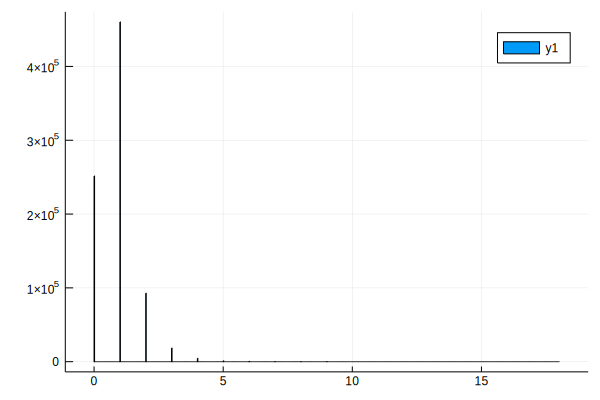

In [14]:
Plots.histogram([lemma["semantic_class_ids"] |> length for lemma in oed_flat])

In [71]:
import HTTP

function fetch_sci(sci)
    r = HTTP.request("GET", "https://oed-api.oxforddictionaries.com/oed/api/v0.1/semanticclass/$sci",
                     ("app_id" => "b0691462", "app_key" => "e924ba24525f6c231fbfeba62ce965ca"))
    JSON.parse(String(r.body))["data"]
end

fetch_sci (generic function with 1 method)

In [75]:
multiclassers = [lemma for lemma in oed_flat if length(lemma["semantic_class_ids"]) > 1];

In [82]:
multiclassers[6]

Dict{String,Any} with 15 entries:
  "part_of_speech"     => "NN"
  "quotation_ids"      => Any["abalone_nn01-5512909", "abalone_nn01-249616709",…
  "main_current_sense" => true
  "first_use"          => "Bayard Taylor"
  "id"                 => "abalone_nn01-5512904"
  "transitivity"       => nothing
  "daterange"          => Dict{String,Any}("rangestring"=>"1850—","start"=>1850…
  "semantic_class_ids" => Any[Any["1", "45969", "45970", "46185", "46320", "463…
  "definition"         => "An edible gastropod mollusc of the genus Haliotis, t…
  "meta"               => Dict{String,Any}("created"=>1933,"updated"=>2011)
  "oed_url"            => "http://www.oed.com/view/Entry/63#eid5512904"
  "word_id"            => "abalone_nn01"
  "lemma"              => "abalone"
  "oed_reference"      => "abalone, n."
  "categories"         => Dict{String,Any}("topic"=>Any[Any["Sciences", "Life S…

In [86]:
multiclassers[6]["semantic_class_ids"] .|> last .|> x -> (x, fetch_sci(x)["breadcrumb"])

2-element Array{Tuple{String,String},1}:
 ("46377", "the world » food and drink » food » animals for food » seafood » [noun] » shell-fish or mollusc » other edible molluscs")                                                                                                     
 ("33032", "the world » animals » invertebrates » subkingdom Metazoa » grade Triploblastica or Coelomata » class Gastropoda » [noun] » superorder Branchifera » order Prosobranchiata » section Holostomata » genus Haliotis » member of")

In [79]:
multiclassers[1]["semantic_class_ids"] .|> last .|> x -> fetch_sci(x)["breadcrumb"]

3-element Array{String,1}:
 "society » society and the community » social class » [noun] » distinction of class » level or grade » specific highest or lowest"                                                            
 "society » society and the community » social class » [noun] » distinction of class » level or grade » specific two highest"                                                                  
 "society » society and the community » social class » the common people » specific classes of common people » [noun] » professional class » specific managerial or administrative » member of"

In [24]:
using StatsBase: countmap

In [57]:
optfirst = x -> if isnothing(x) nothing else get(x, 1, nothing) end
optnth = (x, i) -> if isnothing(x) nothing else get(x, i, nothing) end
countmap([optnth(optnth(lemma["semantic_class_ids"], 4), 1) for lemma in oed_flat])

Dict{Union{Nothing, String},Int64} with 4 entries:
  "1"      => 3080
  "153072" => 2052
  nothing  => 822694
  "122209" => 1145

In [25]:
countmap([lemma["semantic_class_ids"] |> length for lemma in oed_flat]) |> sort

OrderedCollections.OrderedDict{Int64,Int64} with 17 entries:
  0  => 251410
  1  => 460192
  2  => 92714
  3  => 18378
  4  => 4499
  5  => 1150
  6  => 404
  7  => 148
  8  => 43
  9  => 14
  10 => 5
  11 => 6
  12 => 3
  13 => 1
  14 => 2
  15 => 1
  18 => 1

In [20]:
count(x -> x > 1, [lemma["semantic_class_ids"] |> length for lemma in oed_flat]) / length(oed_flat)

0.14158396373335136

In [87]:
# For most lemmas, there will be no synonymy class, as defined below, because there are not enough class ids.
get(1:1, length(1:1)-1, nothing)

In [88]:
# Make direct link to synonym class (most specific semantic classes)
for (i,v) in enumerate(oed_flat)
    #oed_flat[i]["synonymy_classes"] = [get(a,length(a),nothing) for a in v["semantic_class_ids"]]
    
    # currently look for the parent class instead to increase number of synonyms
    oed_flat[i]["synonymy_classes"] = [get(a,length(a)-1,nothing) for a in v["semantic_class_ids"]]
end

In [89]:
# oed_dict = Dict(d["lemma"] => d for d in oed_flat); # terrible idea as many duplicate lemmas
# 
# oed_dict["A"]["semantic_class_ids"] #.|> x -> parse.(Int64,x)
# 
# classes = Iterators.flatten(filter(x->x!="",[get(l["semantic_class_ids"],1,"") for l in oed_flat])) |> unique# .|> x-> parse.(Int64,x)
# 
# 
# G
# 
# table(oed_flat...)
# 
# jsontable(oed_raw_raw)

In [90]:
function dictarr2namedtuple(d)
    names = keys(d[1])
    function col(name)
        map(x -> x[name], d)
    end
    NamedTuple{(Symbol.(names)...,)}([col(name) for name in names])
end

dictarr2namedtuple (generic function with 1 method)

In [91]:
#@time oed_table = jsontable(JSON.json(oed_flat)) |> table # this is v slow (minutes) and not multithreaded, json is rubbish
@time oed_table = table(dictarr2namedtuple(oed_flat)) # this is about 10x faster but leaves the nested dicts as dicts; not sure we care

  5.798747 seconds (4.19 M allocations: 448.198 MiB, 32.18% gc time)


Table with 828971 rows, 16 columns:
Columns:
#   colname             type
────────────────────────────────────────────────────────
1   part_of_speech      Union{Nothing, String}
2   quotation_ids       Array{Any,1}
3   synonymy_classes    Array{T,1} where T
4   main_current_sense  Bool
5   first_use           Union{Nothing, String}
6   id                  String
7   transitivity        Union{Nothing, Dict{String,Any}}
8   daterange           Dict{String,Any}
9   semantic_class_ids  Array{Any,1}
10  definition          Union{Nothing, String}
11  meta                Dict{String,Any}
12  oed_url             String
13  word_id             String
14  lemma               String
15  oed_reference       String
16  categories          Dict{String,Any}

In [92]:
classes = select(oed_table, :semantic_class_ids) |> Iterators.flatten |> Iterators.flatten |> unique

233460-element Array{String,1}:
 "153072"
 "190702"
 "193940"
 "194159"
 "194260"
 "194261"
 "1"     
 "111290"
 "112305"
 "112519"
 "112870"
 "112884"
 "122209"
 ⋮       
 "33343" 
 "18907" 
 "19509" 
 "69621" 
 "69597" 
 "19155" 
 "68086" 
 "68019" 
 "67898" 
 "47084" 
 "70258" 
 "44624" 

In [8]:
# take inspiration from node-conservation-society/julia/{get-adj-mat, lib/process-libraries-io}.jl
#select(oed_table, :daterange)[1:100]

In [93]:
oed_table = setcol(oed_table, :start, :daterange => x -> x["start"])
oed_table = setcol(oed_table, :end, :daterange => x -> x["end"])
oed_table = setcol(oed_table, :obsolete, :daterange => x -> x["obsolete"])
oed_table = setcol(oed_table, :node_id, length(classes)+1:(length(oed_table)+length(classes)))
#oed_table = setcol(oed_table, :node_id, 1:length(oed_table))
reindex(oed_table,:node_id) # this takes a while
# need to think about how to handle "nothing" as end, maybe just special case
# where nothing means it is never switched off
# should also look into what index keys means for juliadb

┌ Warning: `setcol(t, key::Union{Int, Symbol}, val)` is deprecated, use `transform(t, key => val)` instead.
│   caller = top-level scope at In[93]:1
└ @ Core In[93]:1
┌ Warning: `setcol(t, key::Union{Int, Symbol}, val)` is deprecated, use `transform(t, key => val)` instead.
│   caller = top-level scope at In[93]:2
└ @ Core In[93]:2
┌ Warning: `setcol(t, key::Union{Int, Symbol}, val)` is deprecated, use `transform(t, key => val)` instead.
│   caller = top-level scope at In[93]:3
└ @ Core In[93]:3
┌ Warning: `setcol(t, key::Union{Int, Symbol}, val)` is deprecated, use `transform(t, key => val)` instead.
│   caller = top-level scope at In[93]:4
└ @ Core In[93]:4


Table with 828971 rows, 20 columns:
Columns:
#   colname             type
────────────────────────────────────────────────────────
1   node_id             Int64
2   part_of_speech      Union{Nothing, String}
3   quotation_ids       Array{Any,1}
4   synonymy_classes    Array{T,1} where T
5   main_current_sense  Bool
6   first_use           Union{Nothing, String}
7   id                  String
8   transitivity        Union{Nothing, Dict{String,Any}}
9   daterange           Dict{String,Any}
10  semantic_class_ids  Array{Any,1}
11  definition          Union{Nothing, String}
12  meta                Dict{String,Any}
13  oed_url             String
14  word_id             String
15  lemma               String
16  oed_reference       String
17  categories          Dict{String,Any}
18  start               Int64
19  end                 Union{Nothing, Int64}
20  obsolete            Bool

In [10]:
serialize("/home/olie/.dropbox-work/OED/oed_table.jls", oed_table)

In [116]:
function deadyet(last::Nothing, now::Int64)
    return false
end
function deadyet(last::Int64, now::Int64)
    return now > last
end

deadyet (generic function with 2 methods)

In [12]:
#newwords = filter(r -> (r[:start] < 1000) && !r[:obsolete], oed_table)

# Records that are alive in years bounded by the two dates (inclusive)
# Work out what to do with 

# function between_dates_filter(r,start,last)::Bool
#     return (r[:start] <= start) && !deadyet(r[:end],last)
# end
# 
# # This seems to be much slower than it needs to be (e.g. finding earliest word is almost instant - is this doing allocations it shouldn't?)
# # is it slow because r[:end] is a union of nothing and ints?
# records_existing_between_dates(start,last) = filter(r -> between_dates_filter(r, start, last), oed_table)
# 
# dead_words_up_to_date(last) = filter(r -> begin 
#         if (r[:end] == nothing)
#             death = 2014
#         else
#             death = r[:end]
#         end
#         return (death < last)
#     end, oed_table)
# very slow # @time wordsperyear = tmap(y -> records_existing_between_dates(y,y) |> length, years)
# very slow # @time deadwordsperyear = tmap(y -> dead_words_up_to_date(y) |> length, years)

In [13]:
# newwords = records_existing_between_dates(1000,1000)

# Want equivalent of this but with window size

# G = LightGraphs.DiGraph(length(classes) + length(oed_flat))
# 
# class2node = Dict(v => k for (k,v) in enumerate(classes));
# 
# lemmaid2node(id) = id + length(classes)
# 
# #ProgressMeter.@showprogress for (id,lemma) in enumerate(oed_flat[1:10000])
# for (id,lemma) in enumerate(oed_flat)
#     for class in get(lemma["semantic_class_ids"],1,[])
#         LightGraphs.add_edge!(G,lemmaid2node(id),class2node[class])
#     end
# end
# (select(newwords,(:lemma,:start)) |> Dict)#["cissexism"]

# minimum(filter(x->x!=0,select(oed_table,:start))) # Oldest word in dictionary

In [15]:
# years = [700:10:2000..., 2013];
#  # This cell is cool but takes ~5 mins to run
# @time wordsperyear = tmap(y -> (oed_table |> @filter(_[:start] <= y && !deadyet(_[:end],y)) |> collect |> length),years)
# #  
# @time deadwordsperyear = tmap(y -> (oed_table |> @filter(deadyet(_[:end],y)) |> collect |> length),years)
# #  
# #  # Notable dates (https://www.thehistoryofenglish.com nice little site)
# #  # 1066 - Normans
# #  # ~1300s - Mainland Europe does a renaissance
# #  # 1388 - Chaucer
# #  # 1476 - Printing press
# #  # ~1500s - Blighty does a renaissance (Columbian exchange, too)
# #  # ~1590 - Shakespeare 
# #  # 1611 - KJV Bible
# #  # ~1800 - Industrial revolution
# p = Plots.plot(years,wordsperyear,label="Live words")
# Plots.plot!(p,years,deadwordsperyear,legend=:topleft,label="Dead words",xlabel = "Year", ylabel="Number of words", yscale=:log10) 

In [16]:
# This is a slow cell
# Probably makes more sense to have wordsperyear and then filter that down more thoroughly
#regions = [o["categories"]["region"] for o in oed_flat] |> Iterators.flatten |> Iterators.flatten |>  Set
#blacklist = [
#    # Austalasia
#    "Australia",
#    "New Zealand",
#    # North America
#    "United States",
#    # Africa
#    "South Africa",
#    # British Isles
#    "England",
#    "Wales",
#    "Scotland",
#    "Ireland",
#    "Britain",
#    "Northern England",
#    # print(filter((k,v) -> maximum(v) < 1000, wordsperyear) |> keys) # following line is from this
#    "Jamaica", "Northern Ireland", "African-American", "United States Midland", "East Africa", "North-West England", "Eastern United States", "Northern United States", "Southern Scotland", "Southern United States", "India", "Hawaii", "Canada", "Wales", "South-East England", "South-East Asia", "Shetland", "Northern Scotland", "Yorkshire", "English Midlands", "London", "West Africa", "Orkney", "Southern England", "Isle of Man", "Western United States", "North-East England", "Eastern England", "Caribbean", "South-West England"
#] |> Set
#regions = setdiff(regions,blacklist)
#wordsperyear = Dict(region => tmap(
#        y -> (oed_table |> @filter((region in Iterators.flatten(_[:categories]["region"])) && _[:start] <= y && !deadyet(_[:end],y)) |> collect |> length),years
#    ) for region in regions)

In [17]:
#p = Plots.plot()
#for (k,v) in wordsperyear
#    Plots.plot!(p,years,v,legend=:topleft,label=k,xlabel = "Year", ylabel="Number of words", yscale=:log10) 
#end
#p

In [18]:
#Plots.savefig(p,"oed_words_per_year_region.pdf")

In [19]:
# # Another cool but slow cell
# regions = [o["categories"]["region"] for o in oed_flat] |> Iterators.flatten |> Iterators.flatten |>  unique
# Would be cool to do the cell above but a line for each region
# 
# region_counts = tmap(region -> oed_table |> @filter(region in Iterators.flatten(_[:categories]["region"])) |> collect |> length, regions)
# 
# Plots.bar(regions,region_counts;
#     #yscale=:log10,
#     legend=:none,
#     xrotation=:45,
#     xticks=:all,
#     bar_width=0.5,
# )

In [11]:
class2node = Dict(v => k for (k,v) in enumerate(classes));

In [21]:
# oed_flat[1981]["semantic_class_ids"]
# a) some words have multiple semantic classes
# b) the last ID is the most specific one (i.e. actual synonyms reside there)

In [22]:
# Perhaps better from edge list and static graph?
# Think we're just barking up the wrong tree here. semantic_class IDs point to all it is an eventual child of.
# Really quite annoying.
# G = LightGraphs.Graph(length(classes) + length(oed_flat))
# 
# nonempty = oed_table |> @filter(_[:semantic_class_ids] != []) |> table
# 
# for record in nonempty
#     for class in get(record[:semantic_class_ids],1,[])
#         LightGraphs.add_edge!(G,record[:node_id],class2node[class])
#     end
# end
# G

In [23]:
# Hold off on trying to solve semantic problem for now (write that crawler ASAP)

In [114]:
liveatyear(y,t=oed_table) = (t |> @filter(_[:start] <= y && !deadyet(_[:end],y)) |> table)
function graphatyear(y)
    g = LightGraphs.Graph(length(classes) + length(oed_flat))

    for record in liveatyear(y)
        for class in get(record[:semantic_class_ids],1,[])
            LightGraphs.add_edge!(g,record[:node_id],class2node[class])
        end
    end
    g
end

graphatyear (generic function with 1 method)

In [25]:
# G = graphatyear(1990) # could be fun to use this-ish to sketch out when semantic classes die / appear and compare with tensor decomp

In [26]:
# Gs = tmap(graphatyear,years) # Takes of the order of ~ 10-20 minutes

In [27]:
# Next steps:
# Look more at evolution of software communities code
# Write that semantic crawler ASAP
# Figure out what to do with the thingy

In [28]:
# Plots.histogram([length(o["synonymy_classes"]) for o in rand(oed_flat,100000)]) # quite a few have 2+ synonymy classes

In [94]:
synonyms = groupby(table, oed_table, :synonymy_classes); # still need to work out how to deal with multiple classes

In [95]:
# Doesn't make much sense to include the classes in this one
# Should probably make the node_id bit start from zero and have the classes start from the last word
# as it will be easier to exclude them
function synonymyadjatyear(y)
    g = LightGraphs.Graph(length(classes) + length(oed_flat))

    for s in synonyms[2:end] # Exclude the first class as that's the empty one (i.e. not real)
        ids = [n[:node_id] for n in liveatyear(y,s[:table])]
        Iterators.product(ids,ids) .|> e -> LightGraphs.add_edge!(g,e)
    end
    g |> LightGraphs.adjacency_matrix # some stuff has two links which is proper dodgy
end

synonymyadjatyear (generic function with 1 method)

In [15]:
years = 700:10:2014
@time Gs = tmap(synonymyadjatyear,years) # takes about a minute per graph per thread

957.103994 seconds (7.23 G allocations: 387.319 GiB, 27.96% gc time)


132-element Array{SparseArrays.SparseMatrixCSC{Int64,Int64},1}:
 
  [233867 ,  233867]  =  2
  [241881 ,  241881]  =  2
  [242517 ,  242517]  =  2
  [250810 ,  250810]  =  2
  [250874 ,  250874]  =  2
  [250893 ,  250893]  =  2
  [250957 ,  250957]  =  2
  [251044 ,  251044]  =  2
  [251055 ,  251055]  =  2
  [251083 ,  251083]  =  2
  [251215 ,  251215]  =  2
  [251828 ,  251828]  =  2
  ⋮
  [1060697, 1060697]  =  2
  [1060698, 1060698]  =  2
  [1060717, 1060717]  =  2
  [1060718, 1060718]  =  2
  [1060737, 1060737]  =  2
  [1060928, 1060928]  =  2
  [1061655, 1061655]  =  2
  [1061686, 1061686]  =  2
  [1061747, 1061747]  =  2
  [1062347, 1062347]  =  2
  [339949 , 1062354]  =  1
  [1062354, 1062354]  =  2
 
  [233867 ,  233867]  =  2
  [241881 ,  241881]  =  2
  [242517 ,  242517]  =  2
  [250810 ,  250810]  =  2
  [250874 ,  250874]  =  2
  [250893 ,  250893]  =  2
  [250957 ,  250957]  =  2
  [251044 ,  251044]  =  2
  [251055 ,  251055]  =  2
  [251083 ,  251083]  =  2
  [251215 

In [16]:
serialize("/home/olie/.dropbox-work/OED/adj-mats/synonymy.jls", Gs) # NB: don't deal with multiple base-classes yet
# Gs = deserialize("/home/olie/.dropbox-work/OED/adj-mats/synonymy.jls")
# Then need to adapt evolution-of-software-communities/julia/get-r.jl - e.g. make sure to include matlab folder in this directory

In [17]:
serialize("/home/olie/.dropbox-work/OED/synonymy_table.jls", synonyms)

In [3]:
# run cell 1 + 2 then this to skip re-making the table
oed_table = deserialize("/home/olie/.dropbox-work/OED/oed_table.jls")

Table with 828971 rows, 20 columns:
Columns:
#   colname             type
────────────────────────────────────────────────────────
1   part_of_speech      Union{Nothing, String}
2   quotation_ids       Array{Any,1}
3   synonymy_classes    Array{T,1} where T
4   main_current_sense  Bool
5   first_use           Union{Nothing, String}
6   id                  String
7   transitivity        Union{Nothing, Dict{String,Any}}
8   daterange           Dict{String,Any}
9   semantic_class_ids  Array{Any,1}
10  definition          Union{Nothing, String}
11  meta                Dict{String,Any}
12  oed_url             String
13  word_id             String
14  lemma               String
15  oed_reference       String
16  categories          Dict{String,Any}
17  start               Int64
18  end                 Union{Nothing, Int64}
19  obsolete            Bool
20  node_id             Int64

In [5]:
oed_table[1][:semantic_class_ids]

1-element Array{Any,1}:
 Any["153072", "190702", "193940", "194159", "194260", "194261"]

In [96]:
classes = select(oed_table, :semantic_class_ids) |> Iterators.flatten |> Iterators.flatten |> unique

233460-element Array{String,1}:
 "153072"
 "190702"
 "193940"
 "194159"
 "194260"
 "194261"
 "1"     
 "111290"
 "112305"
 "112519"
 "112870"
 "112884"
 "122209"
 ⋮       
 "33343" 
 "18907" 
 "19509" 
 "69621" 
 "69597" 
 "19155" 
 "68086" 
 "68019" 
 "67898" 
 "47084" 
 "70258" 
 "44624" 

In [97]:
class2node = Dict(v => k for (k,v) in enumerate(classes));
class2nodef = x -> class2node[x]

#182 (generic function with 1 method)

In [98]:
classnet = LightGraphs.DiGraph(length(classes))
neighbour_pairs = a -> zip(a[2:end],a[1:end-1])

#184 (generic function with 1 method)

In [99]:
# Walk the lists of semantic class ids to create the thesaurus class tree.

# this is a tiny bit slow so we ought to make sure we don't do this for every graph
for cs in select(oed_table,:semantic_class_ids)
    for x in cs
        neighbour_pairs(x) .|> n -> class2nodef.(n) |> e -> LightGraphs.add_edge!(classnet, e)
    end
end

In [100]:
classnet

{233460, 233457} directed simple Int64 graph

In [109]:
node2class = Dict(v => k for (k,v) in class2node)
node2classf = n -> node2class[n]

#192 (generic function with 1 method)

In [10]:
#LightGraphs.inneighbors(classnet,class2node["1"]) .|> node2classf # this is identical to what /semanticclass/1 reports, job done

# now just need to work out whether to have these nodes in a single layer
# or if it's worth having a second layer

# I think we may as well have a single layer
# Words at the bottom have (un?)directed links to their first semantic class
# turn off all outgoing links from a semantic class if it has no incoming links
# 


In [110]:
LightGraphs.weakly_connected_components(classnet) # these seem to be real disconnected components: the world, society, and the mind

3-element Array{Array{Int64,1},1}:
 [1, 2, 3, 4, 5, 6, 32, 33, 34, 35  …  233385, 233388, 233391, 233393, 233394, 233397, 233422, 233424, 233425, 233429]      
 [7, 8, 9, 10, 11, 12, 60, 61, 62, 63  …  233451, 233452, 233453, 233454, 233455, 233456, 233457, 233458, 233459, 233460]   
 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22  …  233228, 233277, 233338, 233341, 233350, 233387, 233400, 233408, 233423, 233430]

In [111]:
# Once word links have been added, remove semantic classes without any words linking to them
function trim_graph!(g)
    prev_edges = length(LightGraphs.edges(g)) + 1

    while prev_edges > length(LightGraphs.edges(g))
        prev_edges = length(LightGraphs.edges(g))
        for i in 1:length(classes)
            if length(LightGraphs.inneighbors(g,i)) == 0
                for n in LightGraphs.outneighbors(g,i)
                    LightGraphs.rem_edge!(g, i, n)
                end
            end
        end
    end
end

# to-do list:
# - start each year with a copy of classnet (and the extra vertices for the words)
# - swap the current synonymy class linker to instead just add an edge to that synonymy class
    # - if decomp fails, add undirected edge instead (you'll need to check above loop still makes sense)
# - once word links have been added, remove dead semantic class links
# - run decomp on that graph instead and cross fingers
# - labelling will need to be changed so that it skips semantic classes - or you'll have to bite the bullet and scrape the names of them

trim_graph! (generic function with 1 method)

In [112]:
function semanticadjatyear(y,base_g)
    g=deepcopy(base_g)
    LightGraphs.add_vertices!(g,length(oed_table))
    
    for row in liveatyear(y,oed_table)
        for ids in row[:semantic_class_ids]
            # For each array in SCI, add an edge from this node to the last entry in the array (i.e.)
            LightGraphs.add_edge!(g,(row[:node_id],get(class2node,get(ids,length(ids),nothing),nothing))) # the last ID is the one it is most closely related to
        end
    end
    trim_graph!(g)
    g |> LightGraphs.adjacency_matrix # some stuff has two links which is proper dodgy
end
years = 700:10:2014
#@time Gs = tmap(semanticadjatyear,years) # takes about a minute per graph per thread

700:10:2010

In [117]:
semanticadjatyear(1990,classnet)

1062431×1062431 SparseArrays.SparseMatrixCSC{Int64,Int64} with 796597 stored entries:
  [2      ,      1]  =  1
  [32     ,      1]  =  1
  [66     ,      1]  =  1
  [79     ,      1]  =  1
  [92     ,      1]  =  1
  [137    ,      1]  =  1
  [192    ,      1]  =  1
  [263    ,      1]  =  1
  [329    ,      1]  =  1
  [353    ,      1]  =  1
  [376    ,      1]  =  1
  [452    ,      1]  =  1
  ⋮
  [1062355, 233447]  =  1
  [1062361, 233448]  =  1
  [1062364, 233449]  =  1
  [1062373, 233450]  =  1
  [1062388, 233451]  =  1
  [1062393, 233452]  =  1
  [1062394, 233453]  =  1
  [1062395, 233454]  =  1
  [1062396, 233455]  =  1
  [1062402, 233456]  =  1
  [1062403, 233457]  =  1
  [1062423, 233459]  =  1
  [1062429, 233460]  =  1

In [84]:
Gs = []
Threads.@threads for y in years
    push!(Gs,(y,semanticadjatyear(y,classnet)))
end

In [108]:
Gs2 = (sort(Gs,by=x->x[1]) .|> x -> x[2])
serialize("/home/olie/.dropbox-work/OED/adj-mats/semantic.jls", Gs2) # NB: don't deal with multiple base-classes yet

In [118]:
gtest = semanticadjatyear(1990,classnet)
ggtest = LightGraphs.DiGraph(gtest)

1062431×1062431 SparseArrays.SparseMatrixCSC{Int64,Int64} with 796597 stored entries:
  [2      ,      1]  =  1
  [32     ,      1]  =  1
  [66     ,      1]  =  1
  [79     ,      1]  =  1
  [92     ,      1]  =  1
  [137    ,      1]  =  1
  [192    ,      1]  =  1
  [263    ,      1]  =  1
  [329    ,      1]  =  1
  [353    ,      1]  =  1
  [376    ,      1]  =  1
  [452    ,      1]  =  1
  ⋮
  [1062355, 233447]  =  1
  [1062361, 233448]  =  1
  [1062364, 233449]  =  1
  [1062373, 233450]  =  1
  [1062388, 233451]  =  1
  [1062393, 233452]  =  1
  [1062394, 233453]  =  1
  [1062395, 233454]  =  1
  [1062396, 233455]  =  1
  [1062402, 233456]  =  1
  [1062403, 233457]  =  1
  [1062423, 233459]  =  1
  [1062429, 233460]  =  1

{1062431, 796597} directed simple Int64 graph

In [132]:
import MetaGraphs

┌ Info: Precompiling MetaGraphs [626554b9-1ddb-594c-aa3c-2596fe9399a5]
└ @ Base loading.jl:1242


In [137]:
open("semantic1990.dot", "w") do f
    MetaGraphs.savedot(f,MetaGraphs.MetaDiGraph(ggtest))
end

2

No documentation found.

Binding `LightGraphs.savedot` does not exist.
